# What is cPSNR and how is this competition scored?

## The equations

\begin{align}
b = \frac{1}{\mid clear(HR_{u,v})\mid} \left(\sum\limits_{{x, y} \in clear(HR_{u,v})} HR_{u,v}(x,y) - SR(x,y) \right)
\end{align}

\begin{align}
cMSE(HR_{u,v}, SR) = \frac{1}{\mid clear(HR_{u,v})\mid} \sum\limits_{{x, y} \in clear(HR_{u,v})} \left(HR_{u,v}(x,y) - (SR(x,y) + b) \right)^2
\end{align}

\begin{align}
cPSNR(HR_{u,v}, SR) = -10 \cdot \log_{10} \left(cMSE(HR_{u,v}, SR)\right)
\end{align}

\begin{align}
z(SR) = \min_\limits{u, v \in \lbrace 0, \ldots, 6 \rbrace} \left\lbrace \frac{N(HR)}{cPSNR(HR_{u,v}, SR)} \right\rbrace 
\end{align}

The first equation for b.  This equation is calculating a brightness bias for the image.  By subtracting the two images, you can find how much on average one image's pixels are higher or lower than the others.

The next equation cMSE is a traditional MSE that accounts for whether the pixels are clear and by adding the previously calculated bias to the super resolution image.

Next the cPSNR or (Peak Signal to Noise Ratio) is an equation that tries to maximize the good signals (in this case pixels) to the noisy ones.

Finally, is the ratio to the baseline.

## Accounting for shifts

You'll notice in the above equations a u,v vector.  This is because in this competition we are accounting for shifts between the images.  This u,v vector, in this case is all u and v in {0,...,6}, is so that we resize both images from their initial size of 384 to 378 and find which images in this set of images have the minimal score.

## How do we program this?

Well let's take a look.  Let's start by loading numpy and skimage and getting some images loaded.

In [1]:
import numpy as np
import skimage
import matplotlib.pyplot as plt

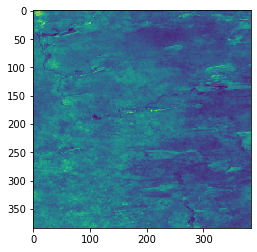

In [2]:
#high resolution image
hr = skimage.io.imread('images/scoring example/HR.png', dtype=np.uint16)
plt.imshow(hr)

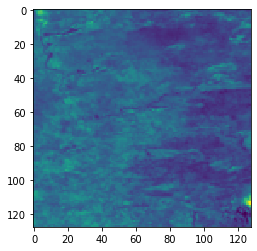

In [3]:
#low resolution images
lrs = []
for i in range(17):
    lrs.append(skimage.io.imread('images/scoring example/LR%03d.png' % i, dtype=np.uint16))
plt.imshow(lrs[0])

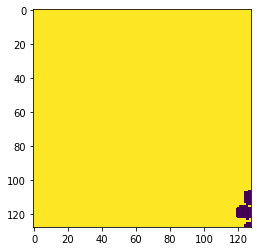

In [4]:
#quality maps
qms = []
for i in range(17):
    qms.append(skimage.io.imread('images/scoring example/QM%03d.png' % i, dtype=np.bool))
plt.imshow(qms[0])

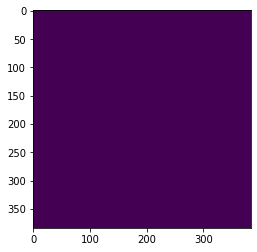

In [5]:
#HR quality map
hr_qm = skimage.io.imread('images/scoring example/SM.png', dtype=np.bool)
plt.imshow(hr_qm)  #This map is all true

## About the data

We know that the data is a 14 bit image stored in a 16 bit png.  So we should expect the max value to be 2^14 - 1 or 16383

In [6]:
np.max(lrs)

28656

We can see above that there are some pixels that go above that threshold.  Let's apply the masks and see if that changes anything.

5744

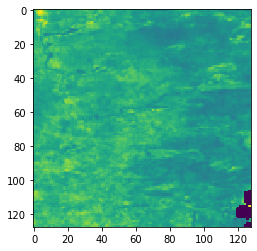

In [7]:
masked_images = []
for i in range(17):
    masked_images.append(lrs[i] * qms[i])
plt.imshow(masked_images[0])
np.max(masked_images)

So we can see above that these masked pixels are the ones that are extending it above the 14 bit limit.

## Making the baseline image

First we have to find the most clear images.  We can do this by looking at the quality maps and finding how many clear pixels there are.

In [8]:
clearances = []
for i in range(17):
    clearances.append(np.sum(qms[i]))
np.where(clearances == np.max(clearances))[0]
clear_images = [lrs[i] for i in np.where(clearances == np.max(clearances))[0]]

In order to process the image through bicubic upscaling, and to avoid errors vs baseline,  we convert the image from int to float and then perform bicbuic interpolation.

In [9]:
def upscale(img):
    img_float = skimage.img_as_float64(img)
    return skimage.transform.rescale(img_float, scale=3, order=3, mode='edge', anti_aliasing=False, multichannel=False)

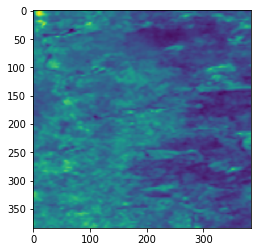

In [10]:
upscaled_image = np.mean([upscale(img) for img in clear_images], axis=0)
plt.imshow(upscaled_image)
hr_float = skimage.img_as_float64(hr)

## Scoring the image

### The first step for scoring the image is create a series of crops to 378x378 varying by the u,v in the {0,...6} vector provided

(378, 378)


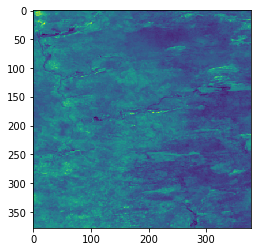

In [11]:
hr_crops = []
hr_qm_crops = []
crops = 6
for i in range(crops + 1):
    for j in range(crops + 1):
        hr_crops.append(hr_float[i : 378 + i, j : 378 + j])
        hr_qm_crops.append(hr_qm[i : 378 + i, j : 378 + j])
plt.imshow(hr_crops[0])
print(hr_crops[0].shape)

### So now that we have the crops we can begin the calculation.  Let's start with the first calculation for the brightness bias.  This is done by subtracting the hr and sr image, with the quality map applied, and calculating the mean.

In [12]:
sr_crop = upscaled_image[3 : -3, 3 : -3]

In [13]:
bs = []
for i in range(len(hr_crops)):
    hr_mapped = hr_crops[i][hr_qm_crops[i]]
    sr_mapped = sr_crop[hr_qm_crops[i]]
    pixel_difference = hr_mapped - sr_mapped
    bs.append(np.mean(pixel_difference))
    
print(bs[0])

0.0037481565962226376


### Next let's expand on the calculation and calculate the 2nd equation which is for the clear MSE

In [14]:
cMSEs = []

for i in range(len(hr_crops)):
    hr_mapped = hr_crops[i][hr_qm_crops[i]]
    sr_mapped = sr_crop[hr_qm_crops[i]]
    pixel_difference = hr_mapped - sr_mapped
    b = np.mean(pixel_difference)
    #Since the pixel difference covers the summation of hr - sr, we simply need to
    #Add in the bias, square it (MSE) and take the mean with respect to clear pixels (cMSE)
    pixel_difference -= b 
    cMSEs.append(np.mean(pixel_difference ** 2))
print(cMSEs[0])

1.5983097738292638e-05


### Finally now we need to calculate the cPSNR which is applying a logarithmic scale and we will then have the score for all the crops

In [15]:
cPSNR = []
for i in range(len(hr_crops)):
    hr_mapped = hr_crops[i][hr_qm_crops[i]]
    sr_mapped = sr_crop[hr_qm_crops[i]]
    pixel_difference = hr_mapped - sr_mapped
    b = np.mean(pixel_difference)
    #Since the pixel difference covers the summation of hr - sr, we simply need to
    #Add in the bias, square it (MSE) and take the mean with respect to clear pixels (cMSE)
    pixel_difference -= b 
    cMSE = np.mean(pixel_difference ** 2)
    cPSNR.append(-10. * np.log10(cMSE))
print(cPSNR[0])

47.963390447800435


### Putting it all together, we then compare this to the score provided in the norm.csv file.  In this case, this is imageset 0000 and the baseline score is 52.352172662454414.  Once we have all these results, we take the minimum score across the set.

In [16]:
scores = []
for i in range(len(hr_crops)):
    hr_mapped = hr_crops[i][hr_qm_crops[i]]
    sr_mapped = sr_crop[hr_qm_crops[i]]
    pixel_difference = hr_mapped - sr_mapped
    b = np.mean(pixel_difference)
    #Since the pixel difference covers the summation of hr - sr, we simply need to
    #Add in the bias, square it (MSE) and take the mean with respect to clear pixels (cMSE)
    pixel_difference -= b 
    cMSE = np.mean(pixel_difference * pixel_difference)
    cPSNR = -10. * np.log10(cMSE)
    scores.append(52.352172662454414 / cPSNR)
print(np.min(scores))

1.0000000000000004


### And that's all!

## So what exactly is cPSNR, and why is it important for this competition?

PSNR stands for (P)eak (S)ignal-to-(N)oise (R)atio.  It is essentially an adjusted MSE.  It attempts to compensate for the noise in the image, in this case that would be the brightness, by logarithmically filtering the MSE.

Without the PSNR in this competition, the biased pixels would have a heavier weight in the final calculation.  For this reason, it's cleaner and more effecient to filter out the noise.